In [ ]:
#batchsize选择
# 模型定义
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import *

# 设置设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# CIFAR-10的类别
classes = ('airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 定义VGG网络配置
cfg = {
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
}

# 定义VGG网络类
class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        self._initialize_weights()
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)




/home/ma-user/anaconda3/envs/PyTorch-1.8.2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


使用设备: cuda:0


In [2]:

# 数据预处理
transform_train = transforms.Compose([
    transforms.ToTensor(),  # 将图像转换为Tensor，同时将像素值从[0, 255]范围缩放到[0.0, 1.0]
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 加载CIFAR-10数据集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)


# 复用之前定义的VGG13模型
model_name = 'VGG13'
base_lr = 0.01  # 使用基础学习率

# 定义要测试的批次大小
batch_sizes_to_test = [64, 128, 256]  # 从小到大的batch size

# 实验参数
epoch_count = 30  # 训练轮数
results = {}

def train_model_with_batch_size(model,batch_size, epochs=30):
    # 创建数据加载器，使用不同的batch size
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=8)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=8)
    

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=base_lr, momentum=0.9, weight_decay=5e-4)
    
    # 使用ReduceLROnPlateau调度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)
    
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    times = []
    lrs = []  # 记录每个epoch的学习率
    memory_usages = []  # 记录内存使用情况
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)
        
        print(f'\n第 {epoch} 轮 - Batch Size: {batch_size} (当前lr={current_lr:.6f})')
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        loop = tqdm(enumerate(trainloader), total=len(trainloader), 
                    desc=f'Training:Epoch [{epoch}/{epochs}]')
        
        for batch_idx, (inputs, targets) in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            loop.set_postfix(loss=loss.item(), acc=correct/total)

        # 计算训练结果
        train_epoch_loss = train_loss / len(trainloader)
        train_epoch_acc = 100. * correct / total
        train_losses.append(train_epoch_loss)
        train_accs.append(train_epoch_acc)
        
        # 测试
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in tqdm(enumerate(testloader), 
                                                  total=len(testloader), 
                                                  desc=f'Testing:'):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        # 计算测试结果
        test_epoch_loss = test_loss / len(testloader)
        test_epoch_acc = 100. * correct / total
        test_losses.append(test_epoch_loss)
        test_accs.append(test_epoch_acc)
        
        epoch_time = time.time() - start_time
        times.append(epoch_time)
        
        # 估计GPU内存使用（仅当使用CUDA时）
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            memory_used = torch.cuda.max_memory_allocated() / (1024 ** 3)  # 转换为GB
            memory_usages.append(memory_used)
            print(f'测试 | 损失: {test_epoch_loss:.3f} | 准确率: {test_epoch_acc:.3f}% | 用时: {epoch_time:.1f}秒 | GPU内存: {memory_used:.2f}GB')
        else:
            print(f'测试 | 损失: {test_epoch_loss:.3f} | 准确率: {test_epoch_acc:.3f}% | 用时: {epoch_time:.1f}秒')
        
        # 更新学习率调度器
        scheduler.step(test_epoch_acc)  # 根据验证准确率调整
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs,
        'times': times,
        'lrs': lrs,
        'memory_usages': memory_usages if torch.cuda.is_available() else [],
        'final_accuracy': test_accs[-1],
        'total_time': sum(times),
        'avg_iter_time': sum(times) / len(times) / (len(trainset) / batch_size)  # 每批次平均时间
    }

# 主实验循环
print("开始 VGG-13 ReduceLROnPlateau 批次大小对比实验...")

# 遍历不同批次大小
for batch_size in batch_sizes_to_test:
    print(f"\n开始训练 VGG-13，批次大小 = {batch_size}")
    # 创建新模型实例
    model = VGG(model_name)
    
    
    # 训练模型并记录结果
    results[f'BatchSize_{batch_size}'] = train_model_with_batch_size(model,batch_size, epochs=epoch_count)
    
    # 保存模型
    torch.save(model.state_dict(), f'cifar10_vgg13_bs{batch_size}.pth')
    print(f"模型已保存为 cifar10_vgg13_bs{batch_size}.pth")

Files already downloaded and verified
Files already downloaded and verified
开始 VGG-13 ReduceLROnPlateau 批次大小对比实验...

开始训练 VGG-13，批次大小 = 64

第 1 轮 - Batch Size: 64 (当前lr=0.010000)


Testing:: 100%|██████████| 157/157 [00:01<00:00, 92.03it/s]

测试 | 损失: 1.481 | 准确率: 39.640% | 用时: 31.9秒 | GPU内存: 0.45GB

第 2 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 89.19it/s]

测试 | 损失: 1.170 | 准确率: 58.700% | 用时: 32.4秒 | GPU内存: 0.45GB

第 3 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 85.68it/s]

测试 | 损失: 0.855 | 准确率: 71.080% | 用时: 32.7秒 | GPU内存: 0.45GB

第 4 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 91.26it/s]

测试 | 损失: 0.911 | 准确率: 70.110% | 用时: 32.5秒 | GPU内存: 0.45GB

第 5 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 87.44it/s]

测试 | 损失: 0.717 | 准确率: 77.620% | 用时: 32.4秒 | GPU内存: 0.45GB

第 6 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 92.92it/s]

测试 | 损失: 0.697 | 准确率: 78.370% | 用时: 32.3秒 | GPU内存: 0.45GB

第 7 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 91.82it/s]

测试 | 损失: 0.672 | 准确率: 79.300% | 用时: 32.3秒 | GPU内存: 0.45GB

第 8 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 92.86it/s]

测试 | 损失: 0.593 | 准确率: 81.950% | 用时: 32.3秒 | GPU内存: 0.45GB

第 9 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 91.38it/s]

测试 | 损失: 0.650 | 准确率: 79.970% | 用时: 32.4秒 | GPU内存: 0.45GB

第 10 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 91.56it/s]

测试 | 损失: 0.623 | 准确率: 80.660% | 用时: 32.4秒 | GPU内存: 0.45GB

第 11 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 91.01it/s]

测试 | 损失: 0.668 | 准确率: 81.410% | 用时: 32.4秒 | GPU内存: 0.45GB

第 12 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 91.19it/s]

测试 | 损失: 0.604 | 准确率: 82.550% | 用时: 32.4秒 | GPU内存: 0.45GB

第 13 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 91.88it/s]

测试 | 损失: 0.630 | 准确率: 82.520% | 用时: 32.5秒 | GPU内存: 0.45GB

第 14 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 91.84it/s]

测试 | 损失: 0.652 | 准确率: 82.950% | 用时: 32.6秒 | GPU内存: 0.45GB

第 15 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 92.09it/s]

测试 | 损失: 0.748 | 准确率: 80.750% | 用时: 32.5秒 | GPU内存: 0.45GB

第 16 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 91.40it/s]

测试 | 损失: 0.713 | 准确率: 82.100% | 用时: 32.5秒 | GPU内存: 0.45GB

第 17 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 92.71it/s]

测试 | 损失: 0.747 | 准确率: 80.980% | 用时: 32.5秒 | GPU内存: 0.45GB

第 18 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 92.23it/s]

测试 | 损失: 0.627 | 准确率: 83.790% | 用时: 32.6秒 | GPU内存: 0.45GB

第 19 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 92.06it/s]

测试 | 损失: 0.658 | 准确率: 83.410% | 用时: 32.4秒 | GPU内存: 0.45GB

第 20 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 91.59it/s]

测试 | 损失: 0.710 | 准确率: 82.830% | 用时: 32.4秒 | GPU内存: 0.45GB

第 21 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 90.61it/s]

测试 | 损失: 0.764 | 准确率: 82.450% | 用时: 32.5秒 | GPU内存: 0.45GB

第 22 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 91.77it/s]

测试 | 损失: 0.703 | 准确率: 84.040% | 用时: 32.5秒 | GPU内存: 0.45GB

第 23 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 91.65it/s]

测试 | 损失: 0.793 | 准确率: 81.670% | 用时: 32.4秒 | GPU内存: 0.45GB

第 24 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 91.77it/s]

测试 | 损失: 0.745 | 准确率: 82.910% | 用时: 32.5秒 | GPU内存: 0.45GB

第 25 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 92.21it/s]

测试 | 损失: 0.710 | 准确率: 83.310% | 用时: 32.4秒 | GPU内存: 0.45GB

第 26 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 91.91it/s]

测试 | 损失: 0.706 | 准确率: 83.520% | 用时: 32.4秒 | GPU内存: 0.45GB

第 27 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 90.53it/s]

测试 | 损失: 0.736 | 准确率: 82.590% | 用时: 32.5秒 | GPU内存: 0.45GB

第 28 轮 - Batch Size: 64 (当前lr=0.010000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 91.63it/s]

测试 | 损失: 0.885 | 准确率: 81.270% | 用时: 32.4秒 | GPU内存: 0.45GB

第 29 轮 - Batch Size: 64 (当前lr=0.001000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 92.06it/s]

测试 | 损失: 0.625 | 准确率: 86.500% | 用时: 32.4秒 | GPU内存: 0.45GB

第 30 轮 - Batch Size: 64 (当前lr=0.001000)



Testing:: 100%|██████████| 157/157 [00:01<00:00, 93.57it/s]


测试 | 损失: 0.658 | 准确率: 86.830% | 用时: 32.4秒 | GPU内存: 0.45GB
模型已保存为 cifar10_vgg13_bs64.pth

开始训练 VGG-13，批次大小 = 128

第 1 轮 - Batch Size: 128 (当前lr=0.010000)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.91it/s]


测试 | 损失: 1.743 | 准确率: 27.190% | 用时: 27.2秒 | GPU内存: 0.78GB

第 2 轮 - Batch Size: 128 (当前lr=0.010000)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.51it/s]

测试 | 损失: 1.384 | 准确率: 48.490% | 用时: 27.3秒 | GPU内存: 0.78GB

第 3 轮 - Batch Size: 128 (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.02it/s]


测试 | 损失: 1.090 | 准确率: 60.310% | 用时: 27.2秒 | GPU内存: 0.78GB

第 4 轮 - Batch Size: 128 (当前lr=0.010000)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.87it/s]

测试 | 损失: 0.927 | 准确率: 68.450% | 用时: 27.2秒 | GPU内存: 0.78GB

第 5 轮 - Batch Size: 128 (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.25it/s]


测试 | 损失: 0.870 | 准确率: 70.750% | 用时: 27.3秒 | GPU内存: 0.78GB

第 6 轮 - Batch Size: 128 (当前lr=0.010000)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.26it/s]

测试 | 损失: 0.848 | 准确率: 72.530% | 用时: 27.3秒 | GPU内存: 0.78GB

第 7 轮 - Batch Size: 128 (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.90it/s]

测试 | 损失: 0.725 | 准确率: 77.040% | 用时: 27.3秒 | GPU内存: 0.78GB

第 8 轮 - Batch Size: 128 (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.89it/s]


测试 | 损失: 0.920 | 准确率: 72.000% | 用时: 27.3秒 | GPU内存: 0.78GB

第 9 轮 - Batch Size: 128 (当前lr=0.010000)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.37it/s]

测试 | 损失: 0.736 | 准确率: 78.110% | 用时: 27.3秒 | GPU内存: 0.78GB

第 10 轮 - Batch Size: 128 (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.80it/s]


测试 | 损失: 0.884 | 准确率: 76.410% | 用时: 27.3秒 | GPU内存: 0.78GB

第 11 轮 - Batch Size: 128 (当前lr=0.010000)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.75it/s]

测试 | 损失: 0.741 | 准确率: 79.190% | 用时: 27.3秒 | GPU内存: 0.78GB

第 12 轮 - Batch Size: 128 (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.46it/s]

测试 | 损失: 0.694 | 准确率: 80.910% | 用时: 27.3秒 | GPU内存: 0.78GB

第 13 轮 - Batch Size: 128 (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.38it/s]

测试 | 损失: 0.699 | 准确率: 82.100% | 用时: 27.3秒 | GPU内存: 0.78GB

第 14 轮 - Batch Size: 128 (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.99it/s]

测试 | 损失: 0.761 | 准确率: 81.210% | 用时: 27.3秒 | GPU内存: 0.78GB

第 15 轮 - Batch Size: 128 (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.06it/s]

测试 | 损失: 0.860 | 准确率: 79.200% | 用时: 27.3秒 | GPU内存: 0.78GB

第 16 轮 - Batch Size: 128 (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.77it/s]

测试 | 损失: 0.734 | 准确率: 81.930% | 用时: 27.3秒 | GPU内存: 0.78GB

第 17 轮 - Batch Size: 128 (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.08it/s]

测试 | 损失: 0.802 | 准确率: 81.710% | 用时: 27.3秒 | GPU内存: 0.78GB

第 18 轮 - Batch Size: 128 (当前lr=0.010000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.49it/s]


测试 | 损失: 0.851 | 准确率: 81.410% | 用时: 27.3秒 | GPU内存: 0.78GB

第 19 轮 - Batch Size: 128 (当前lr=0.010000)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.63it/s]

测试 | 损失: 0.857 | 准确率: 81.060% | 用时: 27.3秒 | GPU内存: 0.78GB

第 20 轮 - Batch Size: 128 (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.18it/s]

测试 | 损失: 0.697 | 准确率: 84.960% | 用时: 27.3秒 | GPU内存: 0.78GB

第 21 轮 - Batch Size: 128 (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.88it/s]


测试 | 损失: 0.735 | 准确率: 85.370% | 用时: 27.3秒 | GPU内存: 0.78GB

第 22 轮 - Batch Size: 128 (当前lr=0.001000)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.10it/s]

测试 | 损失: 0.773 | 准确率: 85.440% | 用时: 27.3秒 | GPU内存: 0.78GB

第 23 轮 - Batch Size: 128 (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.84it/s]


测试 | 损失: 0.804 | 准确率: 85.600% | 用时: 27.3秒 | GPU内存: 0.78GB

第 24 轮 - Batch Size: 128 (当前lr=0.001000)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.36it/s]

测试 | 损失: 0.828 | 准确率: 85.630% | 用时: 27.3秒 | GPU内存: 0.78GB

第 25 轮 - Batch Size: 128 (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.75it/s]

测试 | 损失: 0.845 | 准确率: 85.590% | 用时: 27.3秒 | GPU内存: 0.78GB

第 26 轮 - Batch Size: 128 (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.75it/s]

测试 | 损失: 0.869 | 准确率: 85.630% | 用时: 27.3秒 | GPU内存: 0.78GB

第 27 轮 - Batch Size: 128 (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.29it/s]

测试 | 损失: 0.888 | 准确率: 85.750% | 用时: 27.3秒 | GPU内存: 0.78GB

第 28 轮 - Batch Size: 128 (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.32it/s]

测试 | 损失: 0.890 | 准确率: 85.790% | 用时: 27.4秒 | GPU内存: 0.78GB

第 29 轮 - Batch Size: 128 (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.09it/s]

测试 | 损失: 0.901 | 准确率: 85.750% | 用时: 27.3秒 | GPU内存: 0.78GB

第 30 轮 - Batch Size: 128 (当前lr=0.001000)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.15it/s]


测试 | 损失: 0.925 | 准确率: 85.740% | 用时: 27.3秒 | GPU内存: 0.78GB
模型已保存为 cifar10_vgg13_bs128.pth

开始训练 VGG-13，批次大小 = 256

第 1 轮 - Batch Size: 256 (当前lr=0.010000)


Testing:: 100%|██████████| 40/40 [00:01<00:00, 27.96it/s]

测试 | 损失: 2.144 | 准确率: 17.980% | 用时: 25.1秒 | GPU内存: 1.46GB

第 2 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 27.37it/s]

测试 | 损失: 1.762 | 准确率: 27.790% | 用时: 25.0秒 | GPU内存: 1.46GB

第 3 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 26.89it/s]

测试 | 损失: 1.605 | 准确率: 39.330% | 用时: 25.1秒 | GPU内存: 1.46GB

第 4 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 28.17it/s]

测试 | 损失: 1.648 | 准确率: 39.870% | 用时: 25.0秒 | GPU内存: 1.46GB

第 5 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 28.22it/s]

测试 | 损失: 1.131 | 准确率: 59.780% | 用时: 25.0秒 | GPU内存: 1.46GB

第 6 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 28.06it/s]

测试 | 损失: 1.007 | 准确率: 65.440% | 用时: 25.1秒 | GPU内存: 1.46GB

第 7 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 27.13it/s]

测试 | 损失: 0.882 | 准确率: 70.410% | 用时: 25.1秒 | GPU内存: 1.46GB

第 8 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 28.04it/s]

测试 | 损失: 0.882 | 准确率: 70.840% | 用时: 25.1秒 | GPU内存: 1.46GB

第 9 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 28.85it/s]

测试 | 损失: 0.846 | 准确率: 73.680% | 用时: 25.1秒 | GPU内存: 1.46GB

第 10 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 27.64it/s]

测试 | 损失: 0.880 | 准确率: 71.950% | 用时: 25.0秒 | GPU内存: 1.46GB

第 11 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 27.80it/s]

测试 | 损失: 0.967 | 准确率: 73.570% | 用时: 25.0秒 | GPU内存: 1.46GB

第 12 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 27.60it/s]

测试 | 损失: 0.972 | 准确率: 73.800% | 用时: 25.0秒 | GPU内存: 1.46GB

第 13 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 28.11it/s]

测试 | 损失: 0.970 | 准确率: 74.630% | 用时: 25.1秒 | GPU内存: 1.46GB

第 14 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 27.29it/s]

测试 | 损失: 1.110 | 准确率: 73.520% | 用时: 25.1秒 | GPU内存: 1.46GB

第 15 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 26.90it/s]

测试 | 损失: 1.174 | 准确率: 73.530% | 用时: 25.0秒 | GPU内存: 1.46GB

第 16 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 27.05it/s]

测试 | 损失: 1.132 | 准确率: 74.660% | 用时: 25.0秒 | GPU内存: 1.46GB

第 17 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 28.16it/s]

测试 | 损失: 1.088 | 准确率: 76.200% | 用时: 25.0秒 | GPU内存: 1.46GB

第 18 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 27.44it/s]

测试 | 损失: 1.094 | 准确率: 76.310% | 用时: 25.1秒 | GPU内存: 1.46GB

第 19 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 27.50it/s]

测试 | 损失: 1.024 | 准确率: 78.020% | 用时: 25.1秒 | GPU内存: 1.46GB

第 20 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 27.49it/s]

测试 | 损失: 1.422 | 准确率: 73.540% | 用时: 25.0秒 | GPU内存: 1.46GB

第 21 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 26.78it/s]

测试 | 损失: 1.618 | 准确率: 71.440% | 用时: 25.1秒 | GPU内存: 1.46GB

第 22 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 27.89it/s]

测试 | 损失: 1.417 | 准确率: 74.550% | 用时: 25.1秒 | GPU内存: 1.46GB

第 23 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 27.44it/s]

测试 | 损失: 1.246 | 准确率: 77.190% | 用时: 25.1秒 | GPU内存: 1.46GB

第 24 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 27.42it/s]

测试 | 损失: 1.134 | 准确率: 78.570% | 用时: 25.1秒 | GPU内存: 1.46GB

第 25 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 27.79it/s]

测试 | 损失: 0.995 | 准确率: 79.590% | 用时: 25.0秒 | GPU内存: 1.46GB

第 26 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 28.47it/s]

测试 | 损失: 1.152 | 准确率: 78.450% | 用时: 25.0秒 | GPU内存: 1.46GB

第 27 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 26.93it/s]

测试 | 损失: 1.063 | 准确率: 79.510% | 用时: 25.1秒 | GPU内存: 1.46GB

第 28 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 26.96it/s]

测试 | 损失: 1.067 | 准确率: 80.250% | 用时: 25.1秒 | GPU内存: 1.46GB

第 29 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 27.14it/s]

测试 | 损失: 1.176 | 准确率: 78.430% | 用时: 25.1秒 | GPU内存: 1.46GB

第 30 轮 - Batch Size: 256 (当前lr=0.010000)



Testing:: 100%|██████████| 40/40 [00:01<00:00, 27.55it/s]


测试 | 损失: 1.095 | 准确率: 80.120% | 用时: 25.1秒 | GPU内存: 1.46GB
模型已保存为 cifar10_vgg13_bs256.pth


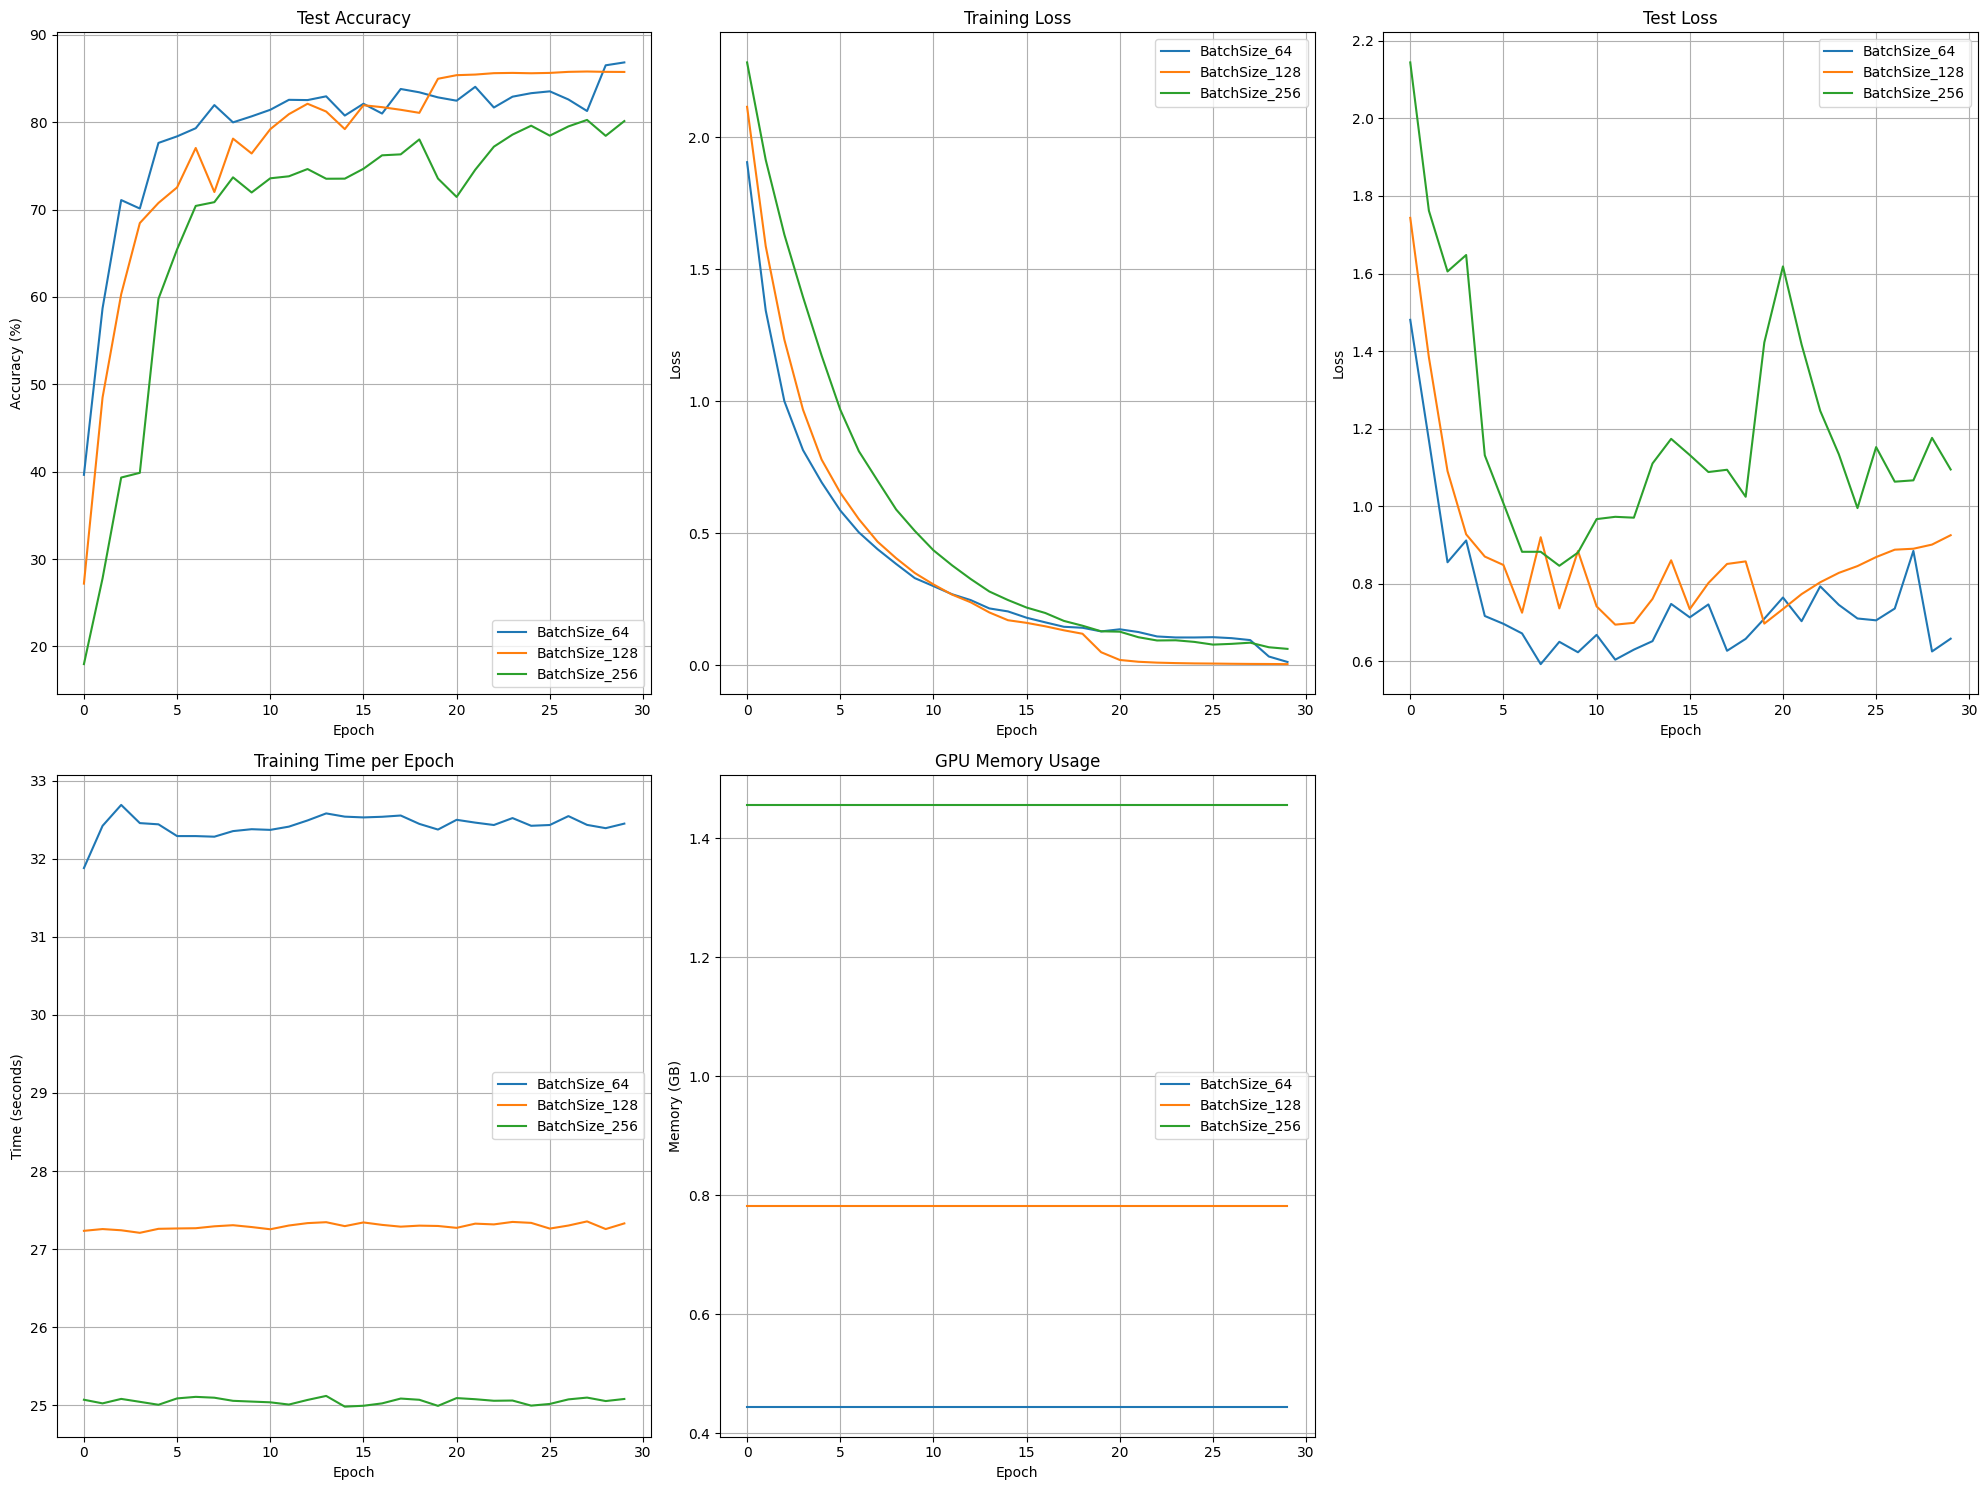


实验结果总结:
----------------------------------------------------------------------------------------------------
批次大小            最终准确率           总训练时间           每轮平均时间          每批次平均时间             
----------------------------------------------------------------------------------------------------
64              86.83          % 972.86         秒 32.43          秒 41.5086             毫秒
128             85.74          % 818.80         秒 27.29          秒 69.8707             毫秒
256             80.12          % 751.65         秒 25.06          秒 128.2818            毫秒
----------------------------------------------------------------------------------------------------


In [4]:
# 可视化不同批次大小的性能比较
plt.figure(figsize=(20, 15))

# 显示测试准确率
plt.subplot(2, 3, 1)
for batch_name in results:
    plt.plot(results[batch_name]['test_accs'], label=batch_name)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# 显示训练损失
plt.subplot(2, 3, 2)
for batch_name in results:
    plt.plot(results[batch_name]['train_losses'], label=batch_name)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 显示测试损失
plt.subplot(2, 3, 3)
for batch_name in results:
    plt.plot(results[batch_name]['test_losses'], label=batch_name)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 显示每轮训练时间
plt.subplot(2, 3, 4)
for batch_name in results:
    plt.plot(results[batch_name]['times'], label=batch_name)
plt.title('Training Time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)

# 显示GPU内存使用情况（如果有）
if torch.cuda.is_available():
    plt.subplot(2, 3, 5)
    for batch_name in results:
        plt.plot(results[batch_name]['memory_usages'], label=batch_name)
    plt.title('GPU Memory Usage')
    plt.xlabel('Epoch')
    plt.ylabel('Memory (GB)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig('vgg13_batch_size_comparison.png')
plt.show()

# 显示实验结果总结
print("\n实验结果总结:")
print("-" * 100)
print(f"{'批次大小':<15} {'最终准确率':<15} {'总训练时间':<15} {'每轮平均时间':<15} {'每批次平均时间':<20}")
print("-" * 100)

for batch_name in results:
    batch_size = int(batch_name.split('_')[1])
    final_acc = results[batch_name]['final_accuracy']
    total_time = results[batch_name]['total_time']
    avg_time = total_time / epoch_count
    avg_iter_time = results[batch_name]['avg_iter_time']
    
    print(f"{batch_size:<15d} {final_acc:<15.2f}% {total_time:<15.2f}秒 {avg_time:<15.2f}秒 {avg_iter_time*1000:<20.4f}毫秒")

print("-" * 100)

